In [1]:
# Importing all the libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from collections import Counter
# packages from gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# packages from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

#packages from nltk
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag

import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df_train=pd.read_csv('malignant_train.csv')

In [3]:
df_test=pd.read_csv('malignant_test.csv')

In [4]:
df_train.head(10)

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [5]:
df_test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [6]:
df_train.shape

(159571, 8)

In [7]:
df_test.shape

(153164, 2)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159571 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [9]:
df_train.columns

Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

In [10]:
df_train.isnull().sum()

id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

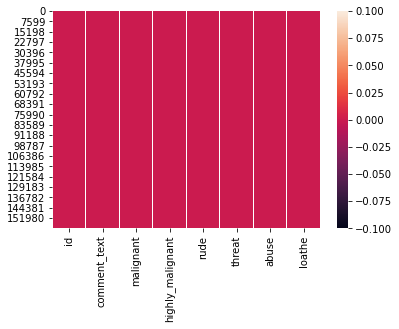

In [11]:
#checking null values using heatmap
sns.heatmap(df_train.isnull())

There are no Null values in this dataset

In [12]:
# Dropping column 'id' since it's of no use
df_train.drop(['id'],axis=1,inplace=True)

In [13]:
df_train.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# EDA

In [14]:
features=df_train.columns[1:]
features

Index(['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe'], dtype='object')

In [15]:
#Checking unique values in each column 
for i in features:
    print('Number of unique values in {} : {}'.format(i, df_train[i].nunique()))

Number of unique values in malignant : 2
Number of unique values in highly_malignant : 2
Number of unique values in rude : 2
Number of unique values in threat : 2
Number of unique values in abuse : 2
Number of unique values in loathe : 2


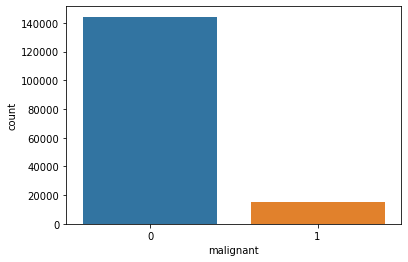

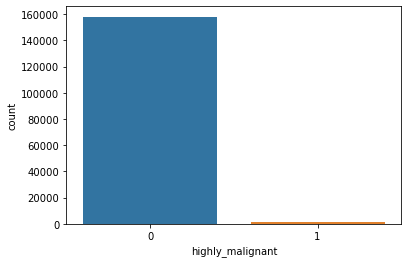

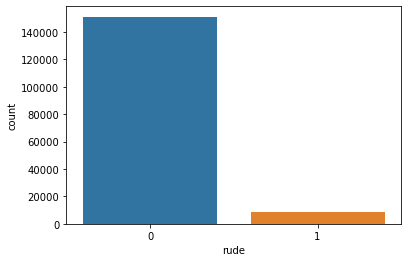

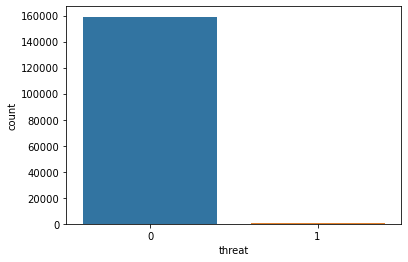

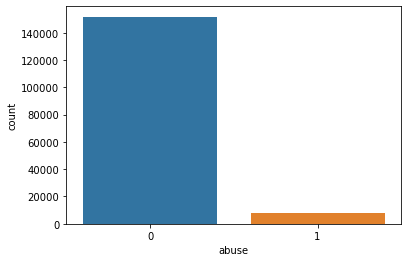

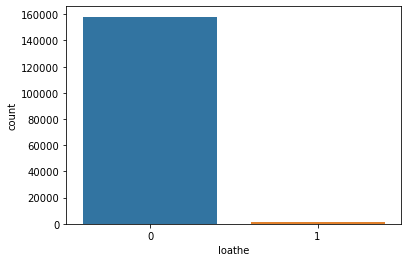

In [16]:
for i in features:
    sns.countplot(df_train[i])
    plt.show()

Most of the comments are non-negative but still there are some highly malignant, rude and abuse comments.

In [17]:
#checking count of Positive and Negative comments in each category
for i in features:
    print('Number of unique values in {} : {}'.format(i, df_train[i].value_counts()))

Number of unique values in malignant : 0    144277
1     15294
Name: malignant, dtype: int64
Number of unique values in highly_malignant : 0    157976
1      1595
Name: highly_malignant, dtype: int64
Number of unique values in rude : 0    151122
1      8449
Name: rude, dtype: int64
Number of unique values in threat : 0    159093
1       478
Name: threat, dtype: int64
Number of unique values in abuse : 0    151694
1      7877
Name: abuse, dtype: int64
Number of unique values in loathe : 0    158166
1      1405
Name: loathe, dtype: int64


In [18]:
#Checking percentage of good and bad comments in dataset
good_comments = df_train[(df_train['malignant']!=1) & (df_train['highly_malignant']!=1) & (df_train['rude']!=1) & 
                            (df_train['threat']!=1) & (df_train['abuse']!=1) & (df_train['loathe']!=1)]
good_percent=len(good_comments)/len(df_train)*100
print('Percentage of good comments = ',good_percent)
print('Percentage of negative comments = ', (100-good_percent))

Percentage of good comments =  89.83211235124176
Percentage of negative comments =  10.167887648758239


In [19]:
# Adding new column comment_length to check length of comment_text characters

df_train['comment_length']=df_train.comment_text.str.len()
df_train

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67
...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,295
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,99
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,81
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0,116


In [20]:
# Adding new column comment_length to check length of comment_text characters
df_test['comment_length']=df_test.comment_text.str.len()
df_test.head()

,id,comment_text,comment_length
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54
3,00017563c3f7919a,":If you have a look back at the source, the in...",205
4,00017695ad8997eb,I don't anonymously edit articles at all.,41


In [21]:
# Creating a new feature having Negative Comments and Non-Negative Comments from all features combinly.
df_train['label'] = df_train[features].max(axis=1)
df_train.head(10)

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_length,label
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,0
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,65,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44,1
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,115,0
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,472,0
9,alignment on this subject and which are contra...,0,0,0,0,0,0,70,0


In [23]:
df_train['label'].value_counts()

0    143346
1     16225
Name: label, dtype: int64

# Pre-Processing the Data

In [ ]:
#nltk.download('averaged_perceptron_tagger')

In [24]:
#Creating a function to filter using POS tagging.

def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [25]:
# Function for data cleaning...
def Processed_data(comments):
    # Replace email addresses with 'email'
    comments=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', comments)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    comments=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',comments)
        
    # getting only words(i.e removing all the special characters)
    comments = re.sub(r'[^\w]', ' ', comments) 
        
    # getting only words(i.e removing all the" _ ")
    comments = re.sub(r'[\_]', ' ', comments) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    comments=re.sub(r'\s+[a-zA-Z]\s+', ' ', comments)
    
    # Removing extra whitespaces
    comments=re.sub(r'\s+', ' ', comments, flags=re.I)

    #converting all the letters of the review into lowercase
    comments = comments.lower()
    
    # splitting every words from the sentences
    comments = comments.split()

    # iterating through each words and checking if they are stopwords or not,
    comments=[word for word in comments if not word in set(STOPWORDS)]
    
    # remove empty tokens
    comments = [text for text in comments if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(comments)

    # considering words having length more than 3only
    comments = [text for text in comments if len(text) > 3]        
   
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS ... 
    comments = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]

   # considering words having length more than 3 only
    comments = [text for text in comments if len(text) > 3]
    comments = ' '.join(comments)
    return comments

In [26]:
# Cleaning  and storing the comments in a separate feature.
df_train["clean_comment_text"] = df_train["comment_text"].apply(lambda x: Processed_data(x))

In [27]:
# Cleaning and storing the comments in a separate feature.
df_test["clean_comment_text"] = df_test["comment_text"].apply(lambda x: Processed_data(x))

In [28]:
# Adding new feature clean_comment_length to store length of cleaned comments in clean_comment_text characters
df_train['clean_comment_length'] = df_train['clean_comment_text'].apply(lambda x: len(str(x)))
df_train.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,comment_length,label,clean_comment_text,clean_comment_length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264,0,explanation edits username hardcore metallica ...,129
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112,0,match background colour seemingly stuck thanks...,64
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233,0,trying edit constantly removing relevant infor...,112
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622,0,real suggestion improvement wondered section s...,315
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67,0,hero chance remember page,25


In [29]:
df_test['clean_comment_length'] = df_test['clean_comment_text'].apply(lambda x: len(str(x)))
df_test.head()

,id,comment_text,comment_length,clean_comment_text,clean_comment_length
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367,bitch rule succesful whats hating mofuckas bit...,184
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50,title fine,10
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54,source zawe ashton lapland,26
3,00017563c3f7919a,":If you have a look back at the source, the in...",205,look source information updated correct form g...,109
4,00017695ad8997eb,I don't anonymously edit articles at all.,41,anonymously edit article,24


In [30]:
# Let's display the wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def Display_wordcloud(data,title):
    feedbackcloud = WordCloud(
        background_color = 'black',
        max_words = 1000,
        max_font_size = 40, 
        scale = 3,
        random_state = 25
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 10),facecolor='g')
    plt.axis('off')
    plt.imshow(feedbackcloud)
    plt.title(f"{title} words")
    plt.show()


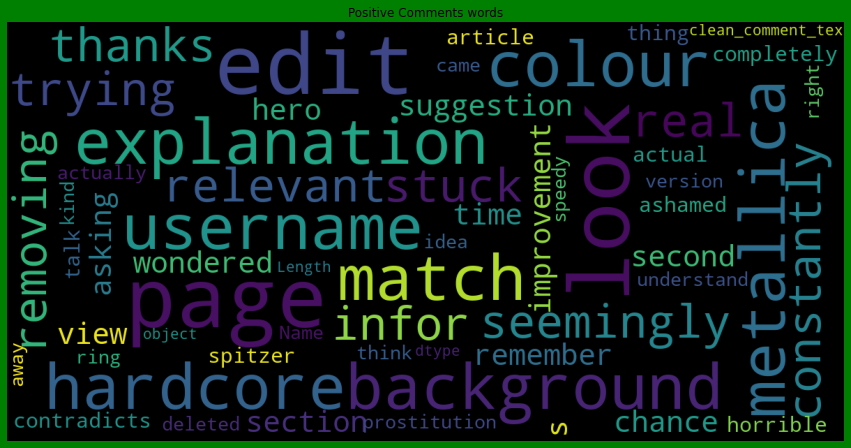

In [31]:
# Non-Negative/Good Comments - in training data
Display_wordcloud(df_train['clean_comment_text'][df_train['label']==0],"Positive Comments")

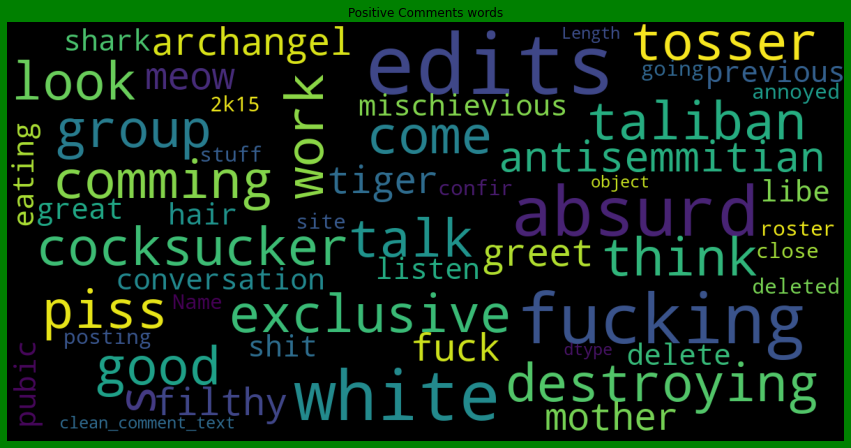

In [32]:
# Negative Comments - in training data
Display_wordcloud(df_train['clean_comment_text'][df_train['label']==1],"Negative Comments")

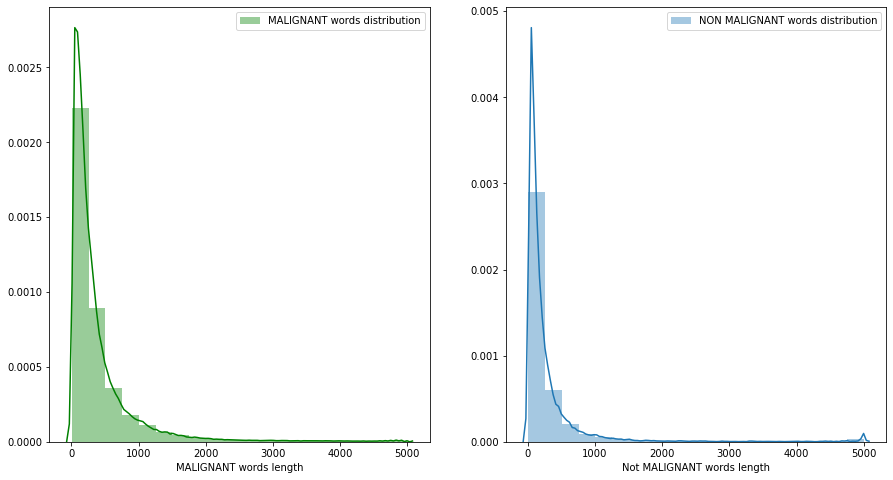

In [33]:
# Comments length distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['label']==0]['comment_length'],bins=20,ax=ax[0],label='MALIGNANT words distribution',color='g')

ax[0].set_xlabel('MALIGNANT words length')
ax[0].legend()

sns.distplot(df_train[df_train['label']==1]['comment_length'],bins=20,ax=ax[1],label='NON MALIGNANT words distribution')
ax[1].set_xlabel('Not MALIGNANT words length')
ax[1].legend()

plt.show()

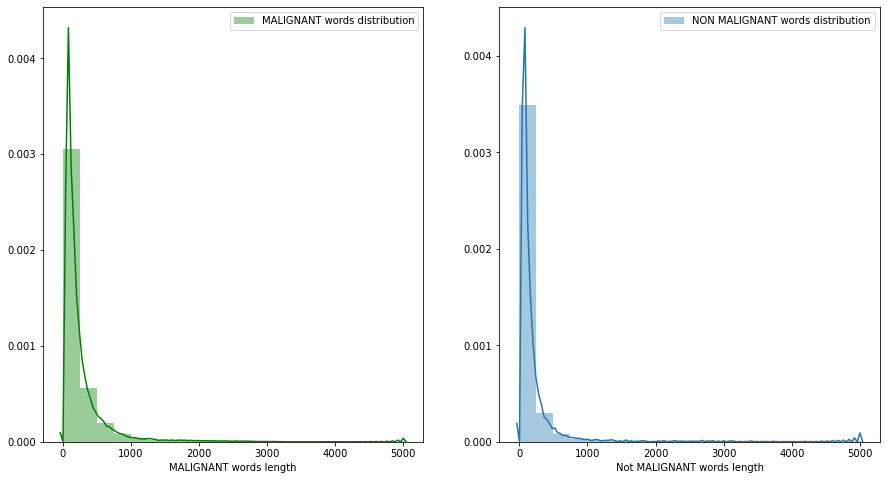

In [34]:
# Comments length distribution after cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(df_train[df_train['label']==0]['clean_comment_length'],bins=20,ax=ax[0],label='MALIGNANT words distribution',color='g')

ax[0].set_xlabel('MALIGNANT words length')
ax[0].legend()

sns.distplot(df_train[df_train['label']==1]['clean_comment_length'],bins=20,ax=ax[1],label='NON MALIGNANT words distribution')
ax[1].set_xlabel('Not MALIGNANT words length')
ax[1].legend()

plt.show()

# Model Building

In [35]:
# TF-IDF(term frequency–inverse document frequency) vectorizer
def Tf_idf_train(text):
    tfid = TfidfVectorizer(min_df=3,smooth_idf=False)
    return tfid.fit_transform(text)

In [36]:
# Splitting the training dataset into x and y
x=Tf_idf_train(df_train['clean_comment_text'])
x.shape

(159571, 43194)

In [37]:

y = df_train['label'].values
y.shape

(159571,)

In [38]:
# Importing libraries for model training

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV


# Importing evaluation metrics for model performance.... 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

In [39]:
#splitting the data into training and testing
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.30,stratify=y)

In [40]:
# Creating instances for different Classifiers

LR=LogisticRegression()
MNB=MultinomialNB()
DT=DecisionTreeClassifier()
KNN=KNeighborsClassifier()
SV=SVC()

In [41]:
# Creating a list model where all the models will be appended for further evaluation in loop.
models=[]
models.append(('LogisticRegression',LR))
models.append(('MultinomialNB',MNB))
models.append(('DecisionTreeClassifier',DT))
models.append(('KNeighborsClassifier',KNN))
models.append(('SVC',SV))


In [ ]:
Model=[]
score=[]
cvs=[]
rocscore=[]
for name,model in models:
    print('**************',name,'***************')
    print('\n')
    Model.append(name)
    model.fit(x_train,y_train)
    print(model)
    pre=model.predict(x_test)
    print('\n')
    AS=accuracy_score(y_test,pre)
    print('Accuracy_score=',AS)
    score.append(AS*100)
    print('\n')
    sc=cross_val_score(model,x,y,cv=5,scoring='accuracy').mean()
    print('Cross_Val_Score=',sc)
    cvs.append(sc*100)
    print('\n')
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test,pre)
    roc_auc=auc(false_positive_rate,true_positive_rate)
    print('roc_auc_score=',roc_auc)
    rocscore.append(roc_auc*100)
    print('\n')
    print('classification report\n',classification_report(y_test,pre))
    print('\n')
    cm=confusion_matrix(y_test,pre)
    print(cm)
    print('\n')
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    print(sns.heatmap(cm,annot=True))
    plt.subplot(912)
    plt.title(name)
    plt.plot(false_positive_rate,true_positive_rate,label='AUC= %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True_Positive_Rate')
    plt.xlabel('False_Positive_Rate')
    print('\n\n')

************** LogisticRegression ***************


LogisticRegression()


Accuracy_score= 0.9531667780748663


Cross_Val_Score= 0.9535128562209592


roc_auc_score= 0.7924918146002661


classification report
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     43004
           1       0.92      0.59      0.72      4868

    accuracy                           0.95     47872
   macro avg       0.94      0.79      0.85     47872
weighted avg       0.95      0.95      0.95     47872



[[42754   250]
 [ 1992  2876]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)



************** MultinomialNB ***************


MultinomialNB()


Accuracy_score= 0.9354737633689839


Cross_Val_Score= 0.9367303554748633


roc_auc_score= 0.6884622511658735


classification report
               precision    recall  f1-score   support

           0       0.93      1.00      0.97     43004
           1       0.97      0.38      0.54      4868

    accuracy        

In [42]:
LR.fit(x_train,y_train)
LR.score(x_train,y_train)
pred=LR.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,pred))
print('Confusion Matrix:',confusion_matrix(y_test,pred))
print('Classification Report:','\n',classification_report(y_test,pred))

Accuracy Score: 0.9531667780748663
Confusion Matrix: [[42754   250]
 [ 1992  2876]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     43004
           1       0.92      0.59      0.72      4868

    accuracy                           0.95     47872
   macro avg       0.94      0.79      0.85     47872
weighted avg       0.95      0.95      0.95     47872



Text(0.5, 1.0, 'Logistic Regression')

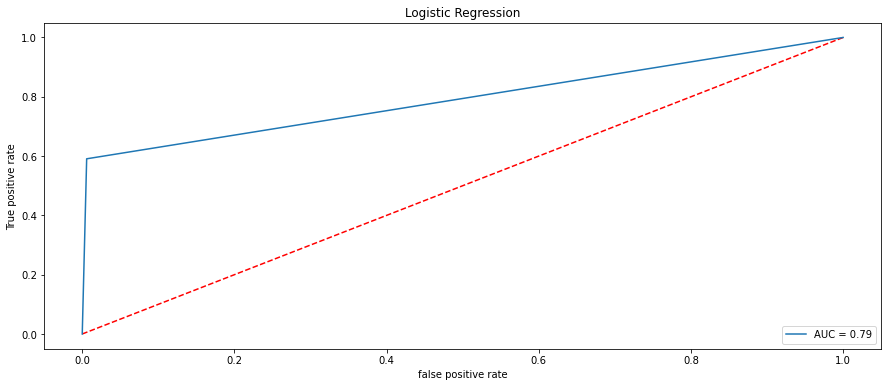

In [43]:
# Roc-Auc score
f,ax = plt.subplots(figsize = (15,6))
# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, pred)
ax.plot([0,1],[0,1],'r--')
ax.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc_score(y_test, pred))
ax.legend(loc='lower right')
ax.set_xlabel('false positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('Logistic Regression')

# Predicting the Dataset

In [44]:
def Tf_idf_test(text):
    tfid = TfidfVectorizer(max_features=43194,smooth_idf=False)
    return tfid.fit_transform(text)

In [45]:
x_test_data=Tf_idf_test(df_test['clean_comment_text'])

In [46]:
x_test_data.shape

(153164, 43194)

In [47]:
Prediction=LR.predict(x_test_data)
df_test['Predicted Labels']=Prediction
df_test

,id,comment_text,comment_length,clean_comment_text,clean_comment_length,Predicted Labels
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,367,bitch rule succesful whats hating mofuckas bit...,184,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,50,title fine,10,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",54,source zawe ashton lapland,26,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",205,look source information updated correct form g...,109,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,41,anonymously edit article,24,0
...,...,...,...,...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu...",60,totally agree stuff long crap,29,0
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...,198,throw field home plate faster throwing direct ...,85,0
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ...",423,okinotorishima category change agree correct g...,212,0
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the...",502,founding nation germany return similar israel ...,275,0


In [48]:
df_test['Predicted Labels'].value_counts()

0    152452
1       712
Name: Predicted Labels, dtype: int64

In [49]:
# Pickle file.
import joblib
joblib.dump(LR,'Malignant_Prediction.pkl')

['Malignant_Prediction.pkl']

In [50]:
df_test.to_csv('Malignant_Predict.csv')